In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, special
import sys
import config
plt.style.use('ggplot')
import os
import time
import datetime
from matplotlib import rc
import plot_cluster_utils as pcu
import statsmodels.formula.api as smf
import seaborn as sns
import figure_utils 
rc('text', usetex=True)
SMALL_SIZE=15
MEDIUM_SIZE=25
rc('legend', fontsize=SMALL_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)

import numpy as np
from numba import jit
from scipy import stats
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from numpy import trapz

plt.style.use("ggplot")

In [2]:
@jit
def SLM(x_0,tau,sgm,K,N,nse,delta_t):
     
    X = [x_0]
    sqrt_delta_t = np.sqrt(delta_t)
    sqrt_sig_tau = np.sqrt(sgm/tau)
    
    for i in range(int(1/delta_t)*N):
        
        X_t = X[-1]
        
        X_t += (X_t/tau)*(1 - X_t/K)*delta_t + sqrt_sig_tau*X_t*nse[i]*sqrt_delta_t        
        
        X.append(X_t)    
    
    return(X)

In [3]:
@jit
def conditional_prob(xt,sigma,tau,K,xrange,delta_t):
    
    mu = xt + (xt/tau*(1-xt/K) * delta_t)
    std = np.sqrt(sigma/tau) * xt * np.sqrt(delta_t)
    
    cond_prob = []
    
    for xval in xrange:
        cond_prob.append((1/std)*np.exp(-1/2*((xval - mu)/std)**2))
    
    return(cond_prob)
    
#@jit
def matrix_power_table(date_diff_set,Y):
    
    YT_dic = {1:Y}
    num = 1
    for diff in date_diff_set:
        YT_temp = YT_dic[num]
        YT_dic[diff] = np.linalg.matrix_power(YT_temp,diff)
    return YT_dic


def make_markov_matrix(sigma,tau,K,xrange,delta_t):
    
    Y = []
    for xt in xrange:
        y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)
     
    for i in range(Y.shape[0]):
    
        Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i])
        Y[i] = Y[i]*xrange_diff
        #Y[i] = np.where(Y[i] == 0,sys.float_info.min,Y[i]) 
        Y[i] = Y[i,:]/sum(Y[i,:])
    
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
    return(Y)

In [4]:
def get_samples(species):
    data_dir = config.data_directory
    snps_dir = f"{data_dir}snps/{species}"

    hosts = ["am","ae","ao","an"]
    tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")
    samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))

    samples_between = {}

    for host in hosts: 
        samples_host = config.Poyet_samples[host]
        samples_host = tp_matched[samples_host].sort_values().index
        samples_host = [sample for sample in samples_host if sample in samples_all]    
        L = len(samples_host)
        if L > 4:
            samples_between[host] = [samples_host[0],samples_host[int(L/4)],samples_host[int(L/2)],samples_host[int(3*L/4)], samples_host[-1]]
    
    return samples_between

In [5]:
def bin_values(timeseries,xrange):

    binned_vals = []
    for elem in timeseries:
        diffarr = np.abs(elem - xrange) 
        binned_vals.append(max(np.argmin(diffarr),1))
    
    binned_vals = np.array(binned_vals)
    return(binned_vals)

In [166]:
species = "Ruminococcus_bromii_62047"
host = "am"
data_dir = config.data_directory
meta_dir = config.metadata_directory
species_dir = f"{data_dir}species/"
snps_dir = f"{data_dir}snps/{species}"

dates = pd.read_pickle(f"{meta_dir}/Poyet_collection_dates.pkl")
dates = pd.DataFrame(dates)
dates["Collection_Date"] = pd.to_datetime(dates.Collection_Date)

rel_ab = pd.read_csv(f"{species_dir}/relative_abundance.txt.bz2",sep="\t",index_col=0)
rel_ab = rel_ab.loc[species]

In [167]:
samples_host = config.Poyet_samples[host]
#samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))
#samples_host = [sample for sample in samples_host if sample in samples_all]

samples_host_dates = dates.loc[samples_host]
samples_host_dates = samples_host_dates.sort_values("Collection_Date")
#rel_ab.loc[samples_host_dates.index][rel_ab.loc[samples_host_dates.index] > 0].index

In [168]:
samples_host = config.Poyet_samples[host]
#samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))


samples_host = [sample for sample in samples_host if rel_ab.loc[sample] > 0]

samples_host_dates = dates.loc[samples_host]
samples_host_dates = samples_host_dates.sort_values("Collection_Date")


samples_host_dates["Date_Diffs"] = samples_host_dates["Collection_Date"].diff().dt.days
samples_host_dates["Date_Diffs"] = samples_host_dates["Date_Diffs"].replace(0.0,1)
samples_host_dates["Date_Diffs"][0] = 0
samples_host_dates["Date_Diffs"] = samples_host_dates["Date_Diffs"].astype(int)
samples_host_dates["Order"] = range(samples_host_dates.shape[0])

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [169]:
species_df = samples_host_dates
species_df["abundance"] = rel_ab


In [170]:
times = np.cumsum(species_df["Date_Diffs"])
times = np.array(list(times))
N = times[-1]

In [171]:
beta = (species_df["abundance"].mean()/species_df["abundance"].std())**2
sigma = 2/(beta+1)

date_diffs = list(species_df["Date_Diffs"])

K = np.mean(species_df["abundance"])
K = K/(1-sigma/2)

dd_set = np.array(sorted(list(set(species_df["Date_Diffs"])))[1:])

delta_t = 1/1000

In [172]:
tau_list = np.linspace(.3,5,60)
bin_list = []

xrange = np.logspace(np.log10(1e-5),np.log10(1),1000)
xrange_diff = xrange[1:] - xrange[:-1]
xrange_diff = np.insert(xrange_diff,0,0)

for elem in species_df["abundance"]:
    diffarr = np.abs(elem - xrange) 
    bin_loc = max(np.argwhere(diffarr == min(diffarr))[0][0],1)
    
    bin_list.append(bin_loc)
    
bin_list = np.array(bin_list)
bin_list
ll_list = []

In [173]:
k = 0
inc = True
while inc and k <= len(tau_list):
    
    Y = []
    tau2 = tau_list[k]
    for xt in xrange:
        y = conditional_prob(xt,sigma,tau2,K,xrange,delta_t)
        y = np.array(y)
        y = y/np.sqrt(2*np.pi)
    
        Y.append(y)

    Y = np.array(Y)
     
    for i in range(Y.shape[0]):
    
        Y[i] = Y[i]*xrange_diff
        
        Y[i] = Y[i,:]/sum(Y[i,:])    
        
    Y = np.linalg.matrix_power(Y,int(1/delta_t))
    
    YT_l = matrix_power_table(dd_set,Y)
    
    lklhds = []

    for i in species_df["Order"][:-1]:
        
        date_diff = species_df.iloc[i+1]["Date_Diffs"]
        Yt = YT_l[date_diff]
        lklhds.append(Yt[bin_list[i],bin_list[i+1]])
        
    ll_list.append(sum(np.log(lklhds)))
    print(sum(np.log(lklhds)))
    
    if k > 1:
        if ll_list[k] < ll_list[k - 1]:
            inc = False
            print("complete")
    k += 1
tau = tau_list[np.argwhere(ll_list == max(ll_list))][0][0]

-1224.760399680938
-1226.1318422734323
-1228.3704125324077
complete


In [174]:
#tau = 1

In [175]:
Y = []
for xt in xrange:
    y = conditional_prob(xt,sigma,tau,K,xrange,delta_t)
    y = np.array(y)
    y = y/np.sqrt(2*np.pi)
    
    Y.append(y)

Y = np.array(Y)    
for i in range(len(Y)):
    
    Y[i] = np.array(Y[i])*xrange_diff
    Y[i] = Y[i,:]/sum(Y[i,:])

Y = np.linalg.matrix_power(Y,int(1/delta_t))
YT_l = matrix_power_table(dd_set,Y)

In [176]:
bin_list_strain = []
for elem in species_df["abundance"]:
    diffarr = np.abs(elem - xrange) 
    bin_list_strain.append(max(np.argmin(diffarr),1))
bin_list_strain = np.array(bin_list_strain)

In [177]:
Q = YT_l[1]
evals, evecs = np.linalg.eig(Q.T)
evec1 = evecs[:,np.isclose(evals, 1)]
evec1 = evec1[:,0]
stationary = evec1 / evec1.sum()
stationary = stationary.real
stationary[stationary <= 0] = 0

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


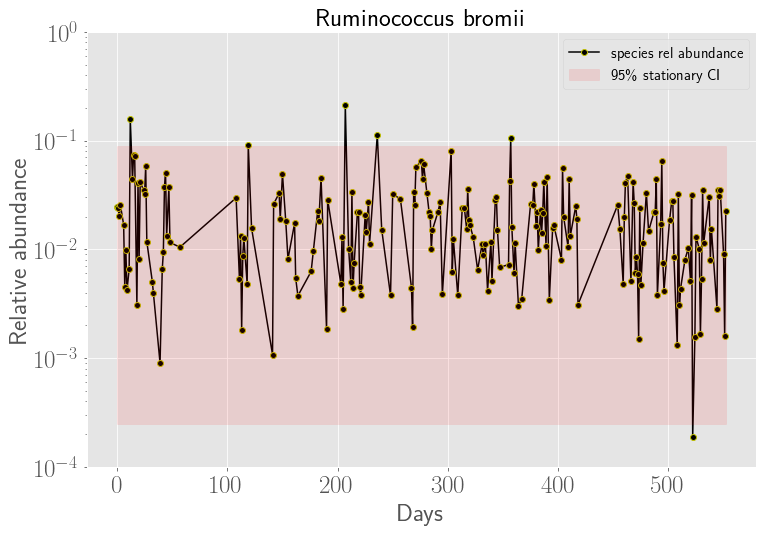

In [178]:
perc = .025
lower = np.argwhere(np.abs(np.cumsum(stationary) - perc) == min(np.abs(np.cumsum(stationary) - perc)))[0][0]
upper = np.argwhere(np.abs(np.cumsum(stationary) - (1-perc)) == min(np.abs(np.cumsum(stationary) - (1-perc))))[0][0]
CI = (xrange[lower],xrange[upper])

fig,ax = plt.subplots(figsize=(12,8))

species_name = figure_utils.get_pretty_species_name(species)

ax.set_title(species_name,size=25)

ax.plot(times,species_df["abundance"], 'o-',color="k",
        label="species rel abundance",markeredgecolor='y',markerfacecolor="k",zorder=1)

ax.fill_between(times,CI[0], CI[1],color='r',alpha=.1,zorder=2,label=f"{int(100*(1-2*perc))}\% stationary CI")

ax.semilogy()

ax.set_ylim([1e-4,1e0])

ax.set_ylabel("Relative abundance",size=25)

ax.set_xlabel("Days",size=25)
ax.legend();

In [179]:
lklhds_data = [stationary[bin_list_strain[0]]]
for i in species_df["Order"][:-1]:
    date_diff = date_diffs[i+1]
    Yt = YT_l[date_diff]
    lklhds_data.append(Yt[bin_list[i],bin_list[i+1]])
data_ll = sum(np.log(lklhds_data))

In [155]:
numsims=int(1e3)
x0 = np.random.choice(xrange,numsims,p=stationary)
t1 = time.time()
X_list = []

for i in range(numsims):
    
    ns = np.random.normal(0, 1, int(N/delta_t))
    simvals = SLM(x0[i],tau,sigma,K,N,ns,delta_t)
    simvals = np.array(simvals[::int(1/delta_t)])
    simvals = simvals[times]
    X_list.append(simvals)
    
t2 = time.time()

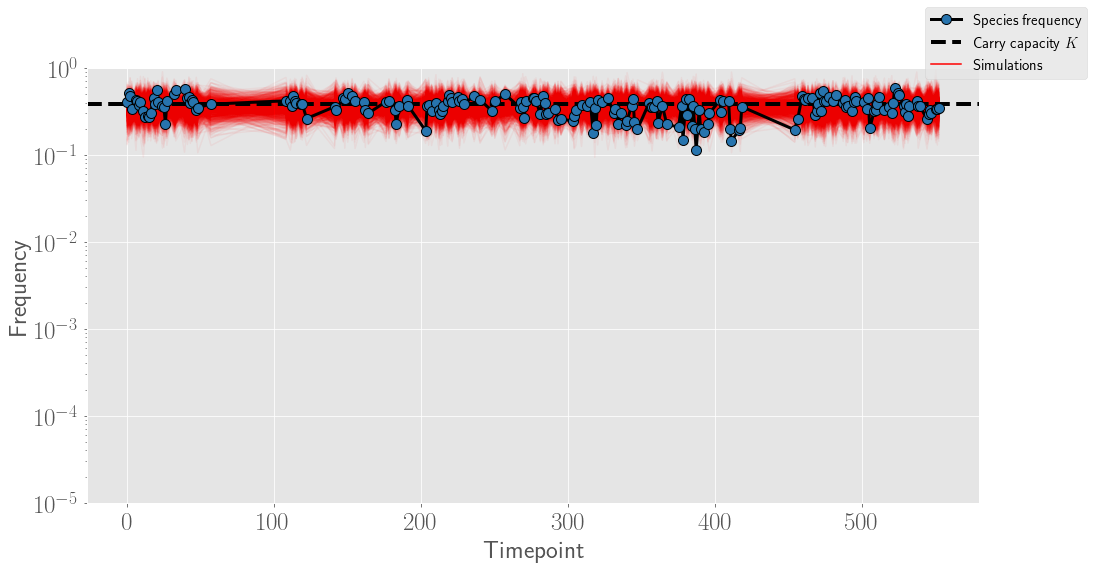

In [156]:
fig,ax = plt.subplots(figsize=(16,8))

for i in range(numsims):
    
    ax.plot(times,X_list[i],alpha=.05,color="red",zorder=1,label=None)

ax.plot(times,species_df["abundance"], 'o-',color="k",
        label="Species frequency",markeredgecolor='k',markerfacecolor="#2774AE",zorder=2,lw=3,
        markersize=10)

ax.axhline(K,color="k",lw = 4,label=r"Carry capacity $K$",linestyle="--",zorder=1)

handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label = 'Simulations',color='red')

handles.extend([line])

ax.set_ylim([1e-5,1])

ax.set_yscale("log")

ax.set_ylabel("Frequency",size=25)

ax.set_xlabel("Timepoint",size=25)

fig.legend(handles=handles);

In [157]:
binned_list = []
for elem in X_list:
    binned_list.append(bin_values(elem,xrange))

In [158]:
log_liks = []

for j in range(numsims):
    
    lklhds = [stationary[binned_list[j][0]]]
    
    for i in range(1, len(times) - 1):
        dd = date_diffs[i+1]
        Yt = YT_l[dd]
    
        lklhds.append(Yt[binned_list[j][i],binned_list[j][i+1]])
        
    log_liks.append(sum(np.log(lklhds)))

Text(0.5, 0, 'Log-likelihood')

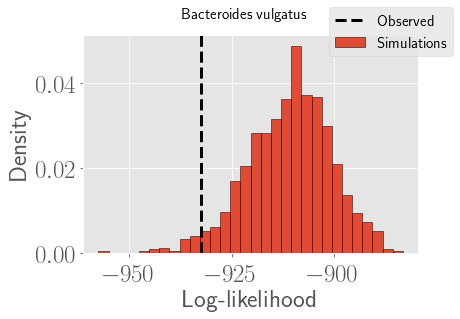

In [159]:
fig_ll, ax_ll = plt.subplots(figsize=(6,4))
fig_ll.suptitle(figure_utils.get_pretty_species_name(species),size=15)

ax_ll.hist(log_liks,density=True,bins=30,label="Simulations",ec="k")

ax_ll.axvline(data_ll,color="k",linestyle="--",linewidth=3,label="Observed");
fig_ll.legend()

ax_ll.set_ylabel("Density",size=25)
ax_ll.set_xlabel("Log-likelihood",size=25)

In [ ]:
species_df

In [ ]:
sum(1*(data_ll > log_liks))/len(log_liks)

In [ ]:
import species_SLM_test

In [ ]:
species_SLM_test.run_SLM(species, host, species_df)

In [ ]:
results

In [180]:
out_path = f"{config.analysis_directory}pi/{species}"

pi_df = pd.read_csv(f"{out_path}/{species}_pi.txt",index_col=0)
fst_df= pd.read_csv(f"{out_path}/{species}_fst.txt",index_col=0)

In [181]:
#outside = species_df[np.logical_or(species_df["abundance"] < CI[0], species_df["abundance"] > CI[1])].index
#inside = species_df[np.logical_and(species_df["abundance"] > CI[0], species_df["abundance"] < CI[1])].index

In [196]:
samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))
samples_div = [sample for sample in samples_host if sample in samples_all]
sample_div =dates.loc[samples_div].sort_values("Collection_Date").index

init_tp = samples_div[0]
species_df["fst"] = fst_df.loc[init_tp,samples_div]

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


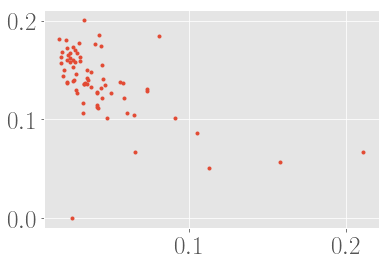

In [197]:
plt.plot(species_df["abundance"],species_df["fst"],".")

In [198]:
weights = np.polyfit(species_df["abundance"],species_df["fst"], 1)
model = np.poly1d(weights)
#results = smf.ols(formula='abundance ~ model(fst)', data=species_df).fit()

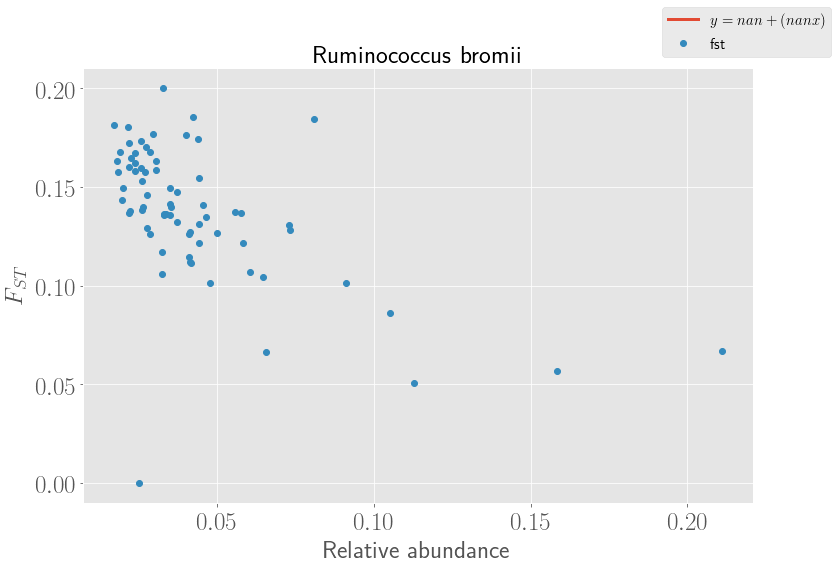

In [199]:
fig,ax = plt.subplots(figsize=(12,8))

ax.plot(species_df["abundance"],model[0] + model[1]*species_df["abundance"],lw=3,label=fr"$y = {np.around(model[0],2)} + ({'{:f}'.format(np.around(model[1],6))}x)$")

ax.plot(species_df["abundance"][1:],species_df["fst"][1:],'o')

species_name = figure_utils.get_pretty_species_name(species)

ax.set_title(species_name,size=25)

for ax in plt.gcf().axes:
    l = ax.get_xlabel()
    ax.set_xlabel(l, fontsize=25)
    
    l = ax.get_ylabel()
    ax.set_ylabel(l, fontsize=25)   

ax.set_ylabel(r"$F_{ST}$",size=25)
ax.set_xlabel("Relative abundance",size=25)
#ax.set_ylim([0,.3])        
    
fig.legend()

fig.savefig(f"{config.analysis_directory}7_6_21_meeting/{species}_{host}_fst_relab.png")

In [200]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [201]:
species_df["times"] = times

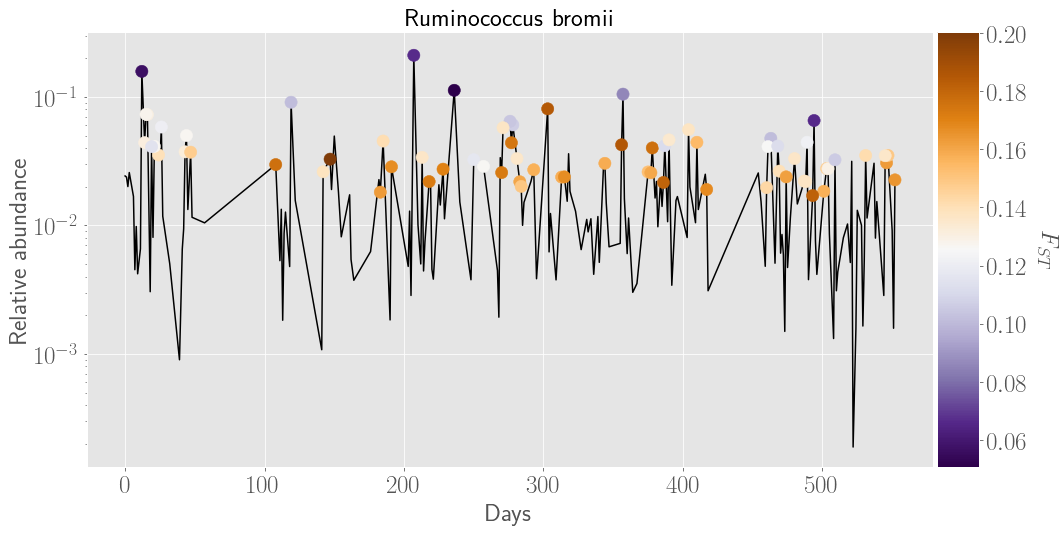

In [202]:
fig,ax = plt.subplots(figsize=(16,8))

ax.set_title(species_name,size=25)

im=ax.scatter(species_df["times"].loc[samples_div][1:],species_df["abundance"].loc[samples_div][1:],c = species_df["fst"].loc[samples_div][1:], s=150,cmap='PuOr_r',zorder=2)
ax.plot(times,species_df["abundance"],zorder=1,c="k")

divider = make_axes_locatable(ax)

cax = divider.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(im,cax=cax, orientation='vertical')

cbar.set_label(r'$F_{ST}$', rotation=270,size=25,labelpad=30)

ax.set_xlabel("Days",size=25)
ax.set_ylabel("Relative abundance",size=25)
ax.semilogy()

fig.savefig(f"{config.analysis_directory}7_6_21_meeting/{species}_{host}_fst_relab_timeseries.png")

In [ ]:
n = 20
d_corrs = [np.corrcoef(species_df["abundance"][1:],species_df["fst"][1:])[0][1]]
for n in range(1,50):
    delay_corr = np.corrcoef(species_df["abundance"][:-n],species_df["fst"][n:])[0][1]
    d_corrs.append(delay_corr)
corr_timeframe = np.argmax(np.abs(d_corrs))

In [ ]:
corr_timeframe

In [ ]:
plt.plot(d_corrs)

In [ ]:
plt.plot(list(species_df["fst"][1:]))
plt.plot(list(species_df["abundance"][1:]))

In [ ]:
np.argmax(d_corrs)

In [ ]:
species_df["abundance"][:3]

In [ ]:
import os

In [ ]:
#fig,ax = plt.subplots(figsize=(12,8))
for species in os.listdir(f"{config.analysis_directory}pi/"):
    samples_host = get_samples(species)
    out_path = f"{config.analysis_directory}pi/{species}"    
    pi_df = pd.read_csv(f"{out_path}/{species}_pi.txt",index_col=0)
    fst_df= pd.read_csv(f"{out_path}/{species}_fst.txt",index_col=0)
    for host in samples_host.keys():
        #ax.plot(list(fst_df.loc[samples_host[host],samples_host[host]].iloc[0]))
        max_diff = fst_df.loc[samples_host[host],samples_host[host]].max().max()
        if max_diff >.4:
            print(f"Replacement {species} {host}")
            print(fst_df.loc[samples_host[host],samples_host[host]])
#ax.semilogy()